<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_Animation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM Animation (v1)
First experiments in animating the agent moving around a floorplan and using its model to perform SLAM.

Here I'm just focused on the preliminary utils I need to extract a trajectory from an image.

In [18]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout be28234
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
import slam_data_test
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)
reload(slam_data_test)

HEAD is now at ebee7f4 Merge remote-tracking branch 'refs/remotes/origin/main'
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 3), reused 5 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (8/8), 213.45 KiB | 4.64 MiB/s, done.
From https://github.com/malcolmlett/robovac
   ebee7f4..29a5ba3  main       -> origin/main
Updating ebee7f4..29a5ba3
Fast-forward
 Experiment_SLAM_Animation_1.ipynb                | 1001 ++++++++++++++++++++++++++++++++++++++++++
 data/experimental-floorplan2-with-trajectory.png |  Bin 3473 -> 3550 bytes
 data/experimental-floorplan2.pdn                 |  Bin 15968 -> 16986 bytes
 3 files changed, 1001 insertions(+)
 create mode 100644 Experiment_SLAM_Animation_1.ipynb


<module 'slam_data_test' from '/content/repo/slam_data_test.py'>

In [8]:
!pip install -Uqq ipdb

from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import imageio
from IPython.display import Image
from google.colab.patches import cv2_imshow
import requests
import math
import ipdb
import tqdm
import time
import gc
import datetime
from timeit import default_timer as timer

In [6]:
# Load floorplan
#floorplan = Image.open('repo/data/experimental-floorplan2-with-trajectory.png')
#floorplan = np.array(floorplan, dtype=np.uint8)
#print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255


## Extract trajectory from floorplan

array([[[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       ...,

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [  0,   0,   0],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]]], dtype=uint8)
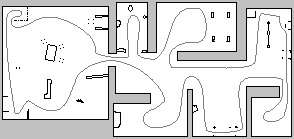

In [19]:
# Load the image
image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
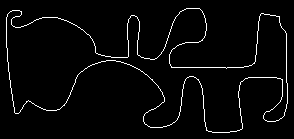

In [20]:
# Load the image
image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')

# Define the color range for the path (replace with actual BGR values)
lower_bound = np.array([127, 127, 127])  # lower BGR bound of the path color
upper_bound = np.array([128, 128, 128])  # upper BGR bound of the path color

# Create a mask to isolate the path based on the color range
mask = cv2.inRange(image, lower_bound, upper_bound)
mask

In [21]:
# Load the image
image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')

# Define the color range for the path (replace with actual BGR values)
lower_bound = np.array([127, 127, 127])  # lower BGR bound of the path color
upper_bound = np.array([128, 128, 128])  # upper BGR bound of the path color

# Create a mask to isolate the path based on the color range
mask = cv2.inRange(image, lower_bound, upper_bound)

# Find contours of the path
# - use CHAIN_APPROX_NONE in order to get coords for every pixel
contours, other = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"contours: {type(contours)} x {len(contours)}")
print(f"contours[0]: {type(contours[0])} x {contours[0].shape}")
print(f"other: {type(other)} x {len(other)}: {other}")

# I think it's a tuple containing one entry for each counter
# Then for each counter we have: (max_len, ?=1, (x,y))

contours: <class 'tuple'> x 1
contours[0]: <class 'numpy.ndarray'> x (1286, 1, 2)
other: <class 'numpy.ndarray'> x 1: [[[-1 -1 -1 -1]]]


In [22]:
# path_coords now holds the (x, y) coordinates along the path
path_coords = contours[0][:,0,:]
print(path_coords)


[[186   8]
 [185   9]
 [184   9]
 ...
 [189   8]
 [188   8]
 [187   8]]


array([[[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       ...,

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [  0,   0,   0],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]]], dtype=uint8)
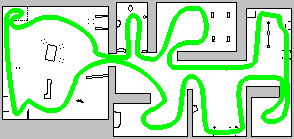

In [26]:
image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
cv2.drawContours(image, [contours[0]], 0, (0,255,0), 3)

In [ ]:
## DON'T EXECUTE THIS CELL.
# Instead of animating, it generates a whole bunch of images in a long chain.

# # Load the image dimensions to create a blank canvas
# original_image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
# height, width, _ = original_image.shape

# # Create a blank canvas to draw the animation
# canvas = np.zeros((height, width, 3), dtype=np.uint8)

# # Parameters for animation
# segment_length = 10  # Number of points per segment to draw
# delay = 50  # Delay in milliseconds between frames

# # Draw the contour in segments
# path = contours[0][:,0,:]
# for i in range(0, path.shape[0], segment_length):
#     segment = path[i:i + segment_length]

#     # Draw the segment on the canvas
#     for point in segment:
#         cv2.circle(canvas, point, radius=1, color=(0, 255, 0), thickness=-1)  # Green path

#     # Display the current frame
#     cv2_imshow(canvas)  # note: using google_colab patched version of cv2.imshow()

#     # Wait for a specified delay
#     if cv2.waitKey(delay) & 0xFF == ord('q'):  # Press 'q' to stop
#         break

# # Clean up
# cv2.destroyAllWindows()


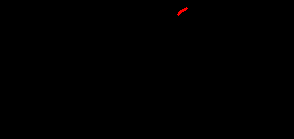

In [25]:
# Generates a GIF file of 7.5K.

# Load the image dimensions to create a blank canvas
original_image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
height, width, _ = original_image.shape

# Create a blank canvas
canvas = np.zeros((height, width, 3), dtype=np.uint8)

# Parameters
segment_length = 10  # Number of points per segment
frames = []  # List to store frames for GIF

# Draw the contour in segments and capture frames
path = contours[0][:,0,:]
prev_segment = None
for i in range(0, path.shape[0], segment_length):
    segment = path[i:i + segment_length]

    # Colour the old segment green
    if prev_segment is not None:
        for point in prev_segment:
            cv2.circle(canvas, point, radius=1, color=(0, 255, 0), thickness=-1)  # Green path

    # Draw the new segment on the canvas in red
    for point in segment:
        cv2.circle(canvas, point, radius=1, color=(0, 0, 255), thickness=-1)  # Green path
    prev_segment = segment

    # Convert to RGB and add to frames list for GIF
    frame_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)

# Save the frames as a GIF
imageio.mimsave("path_animation.gif", frames, duration=0.05)  # Adjust duration as needed

# Display the GIF in the notebook
Image(filename="path_animation.gif")


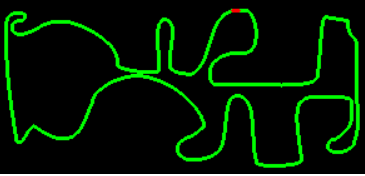

In [15]:
# Generates an MP4 file, of size 214KB

# Load the image dimensions to create a blank canvas
original_image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
height, width, _ = original_image.shape

# Create a blank canvas
canvas = np.zeros((height, width, 3), dtype=np.uint8)

# Parameters
segment_length = 10  # Number of points per segment
fps = 20  # Frames per second for the video

# Define the video writer
video_path = "path_animation.mp4"
print(f"video_path: {video_path}")
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

# Draw the contour in segments and capture frames
path = contours[0][:,0,:]
for i in range(0, path.shape[0], segment_length):
    segment = path[i:i + segment_length]

    # Draw the segment on the canvas
    for point in segment:
        cv2.circle(canvas, point, radius=1, color=(0, 255, 0), thickness=-1)  # Green path

    # Write the frame to the video
    video_writer.write(canvas)

# Release the video writer
video_writer.release()

# Display the MP4 in the notebook
from IPython.display import Video
#Video(filename=video_path, embed=True)
Video(video_path, embed=True)


video_path: path_animation.mp4
